MAPE (Mean Absolute Percentage Error): 0.07016111511667787%
MAE (Mean Absolute Error): 7.866916125981327
RMSE (Root Mean Squared Error): 11.630816621725028


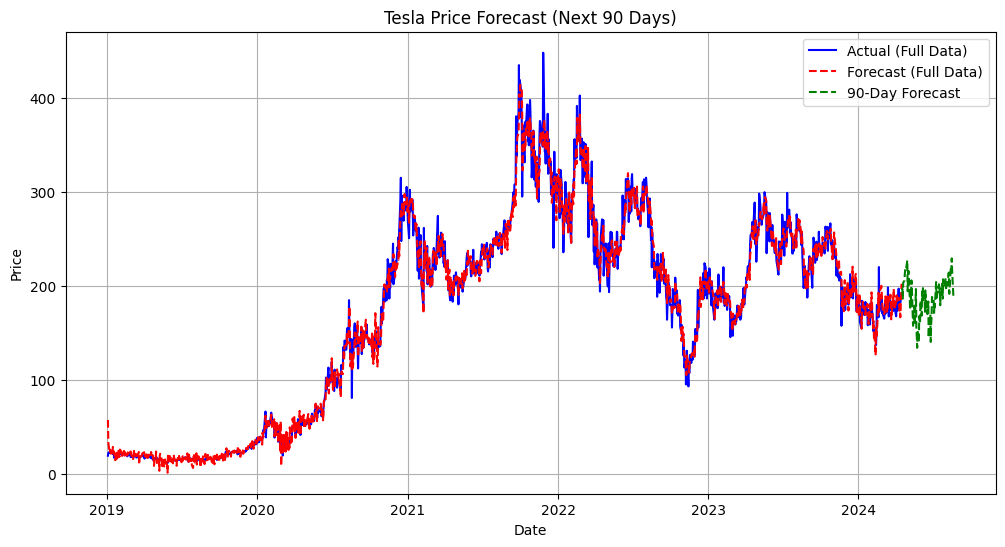

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Step 1: Load the datasets
# Replace 'file_path' with the path or DataFrame variables for your datasets
testla = pd.read_csv('./Clean_data/Cleaned_Tesla_Close.csv', parse_dates=['Date'], index_col='Date')
ixic = pd.read_csv('./Clean_data/Cleaned_SP500_Close.csv', parse_dates=['Date'], index_col='Date')
sp500 = pd.read_csv('./Clean_data/Cleaned_IXIC_Close.csv', parse_dates=['Date'], index_col='Date')
sp500_predicted = sp500['Close_predicted']
ixic_predicted = ixic['Close_predicted']
# Merge the datasets on 'Date' with suffixes to avoid conflicts
exog_data = pd.DataFrame({
    'Close_predicted_sp500': sp500_predicted,
    'Close_predicted_ixic': ixic_predicted,
})

tesla_predicted = testla['Close_predicted']
# Ensure both tesla_predicted and exog_data have the same frequency
tesla_predicted.index = pd.to_datetime(tesla_predicted.index)
exog_data.index = pd.to_datetime(exog_data.index)

# Reindex both dataframes with business day frequency ('B')
tesla_predicted = tesla_predicted.asfreq('B', method=None)
exog_data = exog_data.asfreq('B', method=None)

# Align indices between endogenous and exogenous variables
tesla_predicted, exog_data = tesla_predicted.align(exog_data, join='inner',axis=0)

# Handle missing values in the endogenous and exogenous data
tesla_predicted = tesla_predicted.dropna()
exog_data = exog_data.dropna()

# Re-create the DatetimeIndex with the correct frequency if needed
tesla_predicted.index = pd.date_range(start=tesla_predicted.index[0], periods=len(tesla_predicted), freq='B')
exog_data.index = pd.date_range(start=exog_data.index[0], periods=len(exog_data), freq='B')
# Build the ARIMAX model on the aligned dataset
p, d, q = 1, 0, 1  # You may want to tune these parameters based on your model performance
model = SARIMAX(tesla_predicted[:-90], exog=exog_data[:-90],
                order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Forecast for the entire dataset
forecast = results.fittedvalues

# Synchronize the indices between the forecast and actual data
tesla_predicted, forecast = tesla_predicted.align(forecast, join='inner', axis=0)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(tesla_predicted, forecast)
# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(tesla_predicted, forecast)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(tesla_predicted, forecast))

# Print the results
print(f"MAPE (Mean Absolute Percentage Error): {mape}%")
print(f"MAE (Mean Absolute Error): {mae}")
print(f"RMSE (Root Mean Squared Error): {rmse}")

# Prepare forecast exogenous data for the next 90 days

# Create a DataFrame for the exogenous variables (SP500 and IXIC)
forecast_exog = exog_data[-90:]

# Fill missing values in the exogenous forecast data
forecast_exog = forecast_exog.ffill().bfill()  # Use ffill and bfill directly

# Create a timeline for the next 90 days for forecasting
last_date = tesla_predicted.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='B')

# Ensure the forecast exogenous data has the same frequency as the training data
forecast_exog.index = forecast_dates

# Check if forecast_exog has the same index frequency as tesla_predicted
if forecast_exog.index.freq != tesla_predicted.index.freq:
    print("Warning: forecast_exog index frequency does not match tesla_predicted frequency!")

# Generate forecast for the next 90 days
future_forecast = results.forecast(steps=90, exog=forecast_exog)

# Ensure the forecast has a date index
future_forecast.index = forecast_exog.index

# Plot the actual data, fitted values, and future forecast
plt.figure(figsize=(12, 6))
plt.plot(tesla_predicted, label='Actual (Full Data)', color='blue')
plt.plot(forecast, label='Forecast (Full Data)', color='red', linestyle='--')
plt.plot(future_forecast, label='90-Day Forecast', color='green', linestyle='--')
plt.title('Tesla Price Forecast (Next 90 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
